<a href="https://colab.research.google.com/github/shizacharania/Brain-Tumour-Segmentation/blob/main/Brain_Tumour_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install kaggle
!pip install -q kaggle

In [ ]:
# upload the generated api token in .json format from local system
from google.colab import files
files.upload()

In [ ]:
# make a kaggle directory in my files
!mkdir ~/.kaggle

In [ ]:
# put the kaggle.json file in that directory
!cp kaggle.json ~/.kaggle/

In [ ]:
# grant permission for the .json file to act
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# list available datsets to ensure that the API worked and kaggle's linked
!kaggle datasets list

ref                                                              title                                               size  lastUpdated          downloadCount  
---------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
yasserh/wine-quality-dataset                                     Wine Quality Dataset                                21KB  2022-01-15 19:15:11           7614  
mkoklu42/pistachio-dataset                                       Pistachio Dataset                                    2MB  2022-02-11 21:06:50             63  
prasertk/netflix-subscription-price-in-different-countries       Netflix subscription fee in different countries      3KB  2022-01-15 07:06:09           5857  
majyhain/height-of-male-and-female-by-country-2022               Height of Male and Female by Country 2022            4KB  2022-02-02 00:40:19           3036  
ashishjangra27/ted-talks                

In [ ]:
# download the mri segmentation datset with its api command
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 99% 704M/714M [00:12<00:00, 68.7MB/s]
100% 714M/714M [00:12<00:00, 58.8MB/s]


In [ ]:
# unzip the images from the .zip file so we can directly access these images
!unzip lgg-mri-segmentation.zip

In [ ]:
#visualize the amount of tumours and non-tumours
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import pandas as pd

# path of all the images:
root_path = '/content/lgg-mri-segmentation/kaggle_3m/'

potential_mask_files = glob.glob(root_path + "*/*_mask*") # names of all the files with masks

mask_files = []
add_count = 0
for mask in potential_mask_files: # took most the files that have tumours in them to decrease the dataset since RAM keeps running out
  if np.max(cv2.imread(mask)) > 0:
    mask_files.append(mask)
  elif np.max(cv2.imread(mask)) == 0 and add_count % 3 == 0:
    mask_files.append(mask)
  
  add_count += 1

image_files = []
for mask in mask_files:
  rmask = mask.replace("_mask", "")
  image_files.append(rmask)

print(mask_files) # - e.x.: /content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_23_mask.tif
print(image_files) # - e.x.: /content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_23.tif

tumour_count = []

def diagnosis(mask_path):
    if np.max(cv2.imread(mask_path)) > 0: # return np.max(cv2.imread(mask_path)) - returns 255 if there is a tumour, otherwise returns 0
      tumour_count.append("1")
      return 1
    else:
      tumour_count.append("0")
      return 0

files_df = pd.DataFrame({"image_path": image_files, 
                         "mask_path": mask_files,
                         "diagnosis": [diagnosis(x) for x in mask_files]})

print(files_df)

Tumours: 1373 ........... Non-Tumours: 846


<BarContainer object of 2 artists>

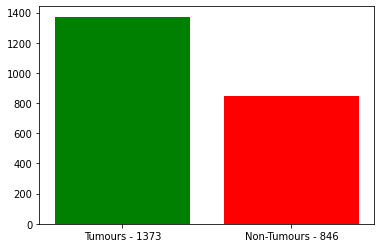

In [ ]:
# to visualize the amount of tumours and non-tumours in the dataset
n_tumours = tumour_count.count("1")
n_nontumours = tumour_count.count("0")

print("Tumours: " + str(n_tumours), "...........", "Non-Tumours: " + str(n_nontumours))

plt.bar(["Tumours - " + str(n_tumours), "Non-Tumours - " + str(n_nontumours)], [n_tumours, n_nontumours], color=["green", "red"])

In [ ]:
# importing libraries
import torch
import torchvision
from torchvision.transforms import transforms

In [ ]:
# finding mean and standard deviation for the dataset
num_pixels = len(image_files)*256*256 #total number of pixels in our dataset

total_sum = 0
for data in image_files:
  image = cv2.imread(data)
  image = torch.from_numpy(image)
  total_sum += image[0].sum() #sum of the current batch of images

mean = total_sum/num_pixels


# std calculated with formula
sum_squared_error = 0
for data in image_files:
  image = cv2.imread(data)
  image = torch.from_numpy(image)
  sum_squared_error += ((image[0] - mean)**2).sum() #adding up the difference between all the elements in the batch and the mean
  
std = torch.sqrt(sum_squared_error/num_pixels) # only one element tensors can be converted to Python scalars, so use torch.sqrt instead of math.sqrt

print("Mean:", mean)
print("Standard Deviation:", std)

Mean: tensor(0.0220)
Standard Deviation: tensor(1.1753)


In [ ]:
image_data = []
mask_data = []

# files are file paths, dataset is empty list that you will append the images too
def loading_data(files, dataset, actions):
  for data in files:
    # reading the image/mask
    image = cv2.imread(data) #makes it a numpy array
            
    # resizing the image/mask
    image = cv2.resize(image, (96, 96))
    # before, I flattened it and it changed a lot because, after the transformations, the tensor changes its composition when rotating or flipping
    # so when setting it to 256x256 again after, there's a weird result

    # convert the PIL image into a PyTorch tensor, cast the int8 values to float32, normalize
    if actions == True: # images
      transform = torchvision.transforms.Compose([transforms.ToTensor(),
                                                  transforms.ConvertImageDtype(torch.float),
                                                  transforms.Normalize((mean, mean, mean), (std, std, std))])
      image = transform(image)

    elif actions == False: # masks
      transform = torchvision.transforms.Compose([transforms.ToTensor(), transforms.ConvertImageDtype(torch.float), transforms.Grayscale()])
      image = transform(image)

    # no blurs needed because the edges need to be clear and precise
    
    dataset.append(image)

In [ ]:
loading_data(image_files, image_data, True)

In [ ]:
loading_data(mask_files, mask_data, False)

In [ ]:
print(len(image_data), len(mask_data))

# split dataset into training, validation, and testing
len_trdataset = int(np.floor(len(image_data) * 0.60))
len_vtdataset = (len(image_data)-len_trdataset)//2

trimage_data = image_data[:len_trdataset]
trmask_data = mask_data[:len_trdataset]

vimage_data = image_data[len_trdataset:(len_trdataset+len_vtdataset)]
vmask_data = mask_data[len_trdataset:(len_trdataset+len_vtdataset)]

testimage_data = image_data[(len_trdataset+len_vtdataset):]
testmask_data = mask_data[(len_trdataset+len_vtdataset):]

print(str(len(trimage_data)), "----", str(len(vimage_data)), "----", str(len(testimage_data)))

2219 2219
1331 ---- 444 ---- 444


In [ ]:
# the normalize function usually goes after data augmentation, but since only the positions of the pixels are changing (when flipping/rotating), it's not a problem

def data_augmentation(dataset): # adding modifications of original images to the dataset
  count = 0
  for image in dataset:
    # since the image is in a tensor, you can use torchvision's transforms
    # list of data augmentation commands
    if count % 9 == 0:
      # 90 degree clockwise rotation
      transform0 = transforms.RandomRotation(degrees=[90,90])
      image = transform0(image)
      dataset.append(image)
    
    elif count % 9 == 1:
      # vertical flip
      transform1 = transforms.RandomVerticalFlip(p=1)
      image = transform1(image)
      dataset.append(image)

    elif count % 9 == 2:
      # horizontal flip 
      transform2 = transforms.RandomHorizontalFlip(p=1)
      image = transform2(image)
      dataset.append(image)

    count += 1

In [ ]:
print(len(trimage_data))
print(len(trmask_data))

# data augmentation
data_augmentation(trimage_data)
data_augmentation(trmask_data)

# print statements to ensure that data augmentation worked
print(len(trimage_data))
print(len(trmask_data))

1331
1331
1997
1997


In [ ]:
from torchvision import utils

# instead of making a classs to retrieve the data, you can zip the images and the masks, make that a tuple, and use that data for the dataloader
training_data = list(zip(trimage_data, trmask_data))
validation_data = list(zip(vimage_data, vmask_data))
testing_data = list(zip(testimage_data, testmask_data))

trainloader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=True)
testingloader = torch.utils.data.DataLoader(testing_data, batch_size=64, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


TEST:
torch.Size([64, 96, 96, 3])
torch.Size([64, 96, 96])
Images:


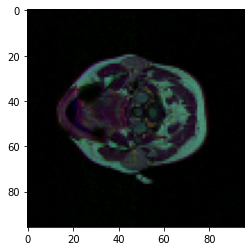

Masks:


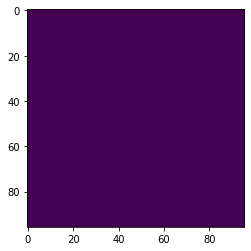



TRAIN:
torch.Size([64, 96, 96, 3])
torch.Size([64, 96, 96])
Images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


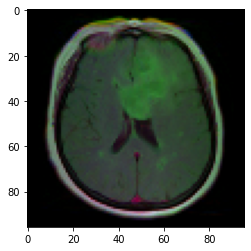

Masks:


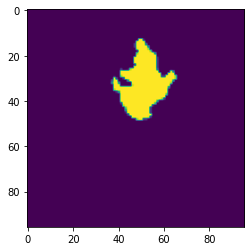

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).




TEST:
torch.Size([64, 96, 96, 3])
torch.Size([64, 96, 96])
Images:


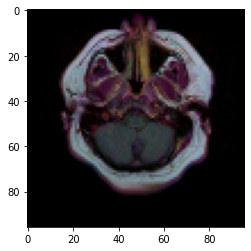

Masks:


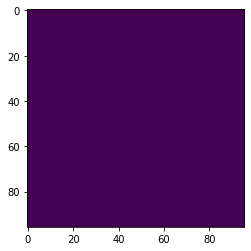

In [ ]:
# testing data
trimages, trmasks = next(iter(trainloader))

trimages = trimages.permute((0,2,3,1))
trmasks = trmasks.permute((0,2,3,1))
trmasks = trmasks.squeeze()

print("TEST:")
print(trimages.shape)
print(trmasks.shape) # greyscaled

print("Images:")
plt.imshow(trimages[3])
plt.show()
print("Masks:")
plt.imshow(trmasks[3])
plt.show()

print("\n")

# validation data
vimages, vmasks = next(iter(validationloader))

vimages = vimages.permute((0,2,3,1))
vmasks = vmasks.permute((0,2,3,1))
vmasks = vmasks.squeeze()

print("TRAIN:")
print(vimages.shape)
print(vmasks.shape) # greyscaled

print("Images:")
plt.imshow(vimages[1])
plt.show()
print("Masks:")
plt.imshow(vmasks[1])
plt.show()

print("\n")

# testing data
testimages, testmasks = next(iter(testingloader))

testimages = testimages.permute((0,2,3,1))
testmasks = testmasks.permute((0,2,3,1))
testmasks = testmasks.squeeze()

print("TEST:")
print(testimages.shape)
print(testmasks.shape) # greyscaled

print("Images:")
plt.imshow(testimages[0])
plt.show()
print("Masks:")
plt.imshow(testmasks[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

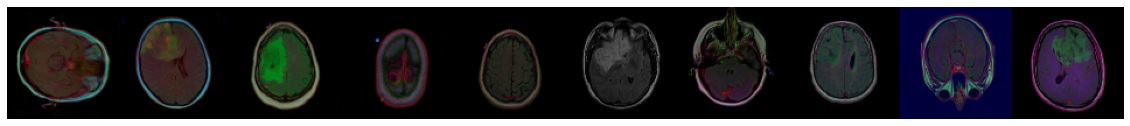

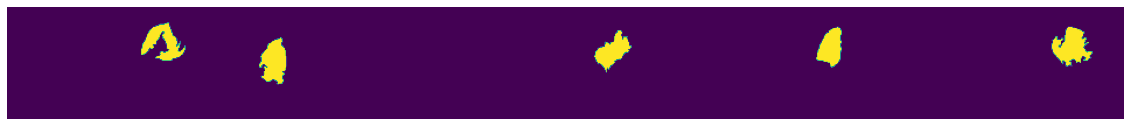

In [ ]:
# visualize the images
def show_aug(loader, nrows=4, ncols=10):
    
    images, masks = next(iter(loader))
    images = images.permute((0,2,3,1))
    masks = masks.permute((0,2,3,1))
    masks = masks.squeeze()

    plt.figure(figsize=(20, 20))
    for i in range(len(images[:10])):
      plt.subplot(nrows, ncols, i+1)
      plt.imshow(images[i])
      plt.axis('off')
      plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

    plt.figure(figsize=(20, 20))
    for j in range(len(masks[:10])):
      plt.subplot(nrows, ncols, j+1)
      plt.imshow(masks[j])
      plt.axis('off')
      plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

show_aug(trainloader)

In [ ]:
# build the u-net model
import torch.nn as nn
import torchvision.transforms.functional as tf

In [ ]:
# class for unet model
class ConvBlock(nn.Module): #one individual one for bottleneck
  def __init__(self, in_channels, out_channels): # no need to input k_size, stride, or padding since that's always constant
    super(ConvBlock, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=(3,3), stride=1, padding=1)
    self.batchnorm = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()
  def forward(self, x):
    x = self.conv(x)
    x = self.batchnorm(x)
    x = self.relu(x)
    return x

class StackEncoder(nn.Module):
  def __init__(self, in_channels, out_channels): # no need to input k_size, stride, or padding since that's always constant
    super(StackEncoder, self).__init__()
    self.max_pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
    self.block = nn.Sequential(
        ConvBlock(in_channels, out_channels),
        ConvBlock(out_channels, out_channels))
  def forward(self, x):
    block_out = self.block(x)
    pool_out = self.max_pool(block_out)
    return block_out, pool_out # we have this, so when it concatenates, it does concatenation before pooling
    
class StackDecoder(nn.Module):
  def __init__(self, in_channels, out_channels): # no need to input k_size, stride, or padding since that's always constant
    super(StackDecoder, self).__init__()
    self.block = nn.Sequential(
        ConvBlock(in_channels+in_channels, out_channels),
        ConvBlock(out_channels, out_channels))
    
  def forward(self, x, concat_tensor): #down tensor is to concatenate
    batch, channels, height, width = concat_tensor.shape
    x = torch.nn.functional.interpolate(x, size=(height, width)) # i used this instead of trans_cov because i needed to crop the size before passing it on & trans conv couldn't do that
    x = torch.cat([x, concat_tensor], 1)
    blockout = self.block(x)
    return blockout

class UNET(nn.Module):
  def __init__(self, input_shape):
    super(UNET, self).__init__()

    self.batch, self.channel, self.height, self.width = input_shape

    # 96 x 96 x 3
    self.down1 = StackEncoder(self.channel, 64)
    # 48 x 48 x 64
    self.down2 = StackEncoder(64, 128)
    # 24 x 24 x 128
    self.down3 = StackEncoder(128, 256)
    # 12 x 12 x 256
    self.bottleneck = ConvBlock(256, 256)
    # 12 x 12 x 256
    self.up3 = StackDecoder(256, 128)
    # 24 x 24 x 128
    self.up2 = StackDecoder(128, 64)
    # 48 x 48 x 64
    self.up1 = StackDecoder(64, 1)
    # 96 x 96 x 1


  def forward(self, x):
    down1, out = self.down1(x)
    down2, out = self.down2(out)
    down3, out = self.down3(out)

    bottleneck = self.bottleneck(out)

    up3 = self.up3(x=bottleneck, concat_tensor=down3)
    up2 = self.up2(x=up3, concat_tensor=down2)
    up1 = self.up1(x=up2, concat_tensor=down1)
    
    return up1

In [ ]:
inp = torch.rand(1,3,96,96) #batch size = 1 + image = 3 x 96 x 96
print(inp.shape)

model = UNET(inp.shape)
print(model)

out = model(inp)
print(out.shape)

torch.Size([1, 3, 96, 96])
torch.Size([1, 1, 96, 96])


In [ ]:
from torch import optim
import datetime

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
trlosses = []
vlosses = []

epochs = 11

for epoch in range(epochs):
  startepoch = datetime.datetime.now()
  #training
  training_loss = 0
  validation_loss = 0
  model.train()
  for images, masks in trainloader:
    images, masks = next(iter(trainloader))
    masks = masks.squeeze()
    optimizer.zero_grad() # clear gradients
    output = model(images)
    output = output.squeeze(1)
    loss = criterion(output, masks)
    loss.backward()
    optimizer.step()

    training_loss += loss.item()

  # validation
  model.eval()

  for images, masks in validationloader:
    images, masks = next(iter(validationloader))
    masks = masks.squeeze()
    
    out = model(images)
    out = out.squeeze(1)
    loss = criterion(out, masks)

    validation_loss += loss.item()
  
  mean_tloss = training_loss/(len(trainloader))
  mean_vloss = validation_loss/len(validationloader)

  trlosses.append(mean_tloss)
  vlosses.append(mean_vloss)

  print("Epoch: {}  ...".format(epoch+1), "Training Loss: {:.4f}  ...".format(trlosses[-1]), "Validation Loss: {:.4f} ...".format(vlosses[-1]))

  if vlosses[-1] <= min(vlosses):
    print("Validation Loss has decreased - saving")
    torch.save(model.state_dict(), "brainmrisegmentation.pth")
  
  endepoch = datetime.datetime.now()

  print("Epoch time:", str(endepoch-startepoch), "\n")

Epoch: 1  ... Training Loss: 6.9766  ... Validation Loss: 9.0647 ...
Validation Loss has decreased - saving
Epoch time: 0:05:39.655974 

Epoch: 2  ... Training Loss: 5.8172  ... Validation Loss: 7.5562 ...
Validation Loss has decreased - saving
Epoch time: 0:05:36.877421 

Epoch: 3  ... Training Loss: 5.7804  ... Validation Loss: 7.8845 ...
Epoch time: 0:05:34.679717 

Epoch: 4  ... Training Loss: 5.5231  ... Validation Loss: 7.9698 ...
Epoch time: 0:05:36.389262 

Epoch: 5  ... Training Loss: 5.5964  ... Validation Loss: 8.2659 ...
Epoch time: 0:05:35.291738 

Epoch: 6  ... Training Loss: 5.2754  ... Validation Loss: 7.7214 ...
Epoch time: 0:05:34.556057 

Epoch: 7  ... Training Loss: 5.2659  ... Validation Loss: 6.9224 ...
Validation Loss has decreased - saving
Epoch time: 0:05:34.376057 

Epoch: 8  ... Training Loss: 5.7161  ... Validation Loss: 7.4404 ...
Epoch time: 0:05:35.021796 

Epoch: 9  ... Training Loss: 5.4398  ... Validation Loss: 7.3676 ...
Epoch time: 0:05:35.801307 

E

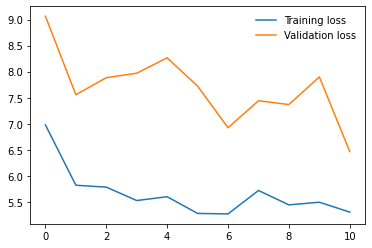

In [ ]:
# visualize losses

plt.plot(trlosses, label="Training loss")
plt.plot(vlosses, label="Validation loss")
plt.legend(frameon=False)

# validation loss was fluctuating a lot, so I lowered my learning rate + make # of images in validation a bit higher

In [ ]:
# load saved model and its parameters
loaded_model = torch.load("brainmrisegmentation.pth")
model.load_state_dict(loaded_model)

<All keys matched successfully>

In [ ]:
# testing
epochs = 1
testing_loss = 0
correct_pixels = 0
total_pixels = 0

for images, masks in testingloader:
  images, masks = next(iter(testingloader))
  masks = masks.squeeze()
  out = model(images)
  out = out.squeeze(1)
  loss = criterion(out, masks)
  testing_loss += loss.item()

  preds = (out > 0.5).float()
  correct_pixels += (preds == masks).sum()
  # print(torch.numel(preds), len(preds)) # 589824 64
  total_pixels += torch.numel(preds) # number of elements (pixels) in each predicitions (96x96x64 = 589824)

accuracy = correct_pixels / total_pixels
print("Got {}/".format(correct_pixels) + "{}".format(total_pixels) + " correct with an accuracy of {:.2f}%".format(accuracy*100))

Got 3507247/4128768 correct with an accuracy of 84.95%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


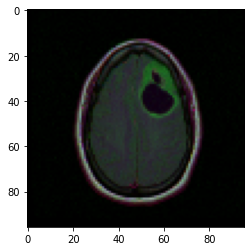

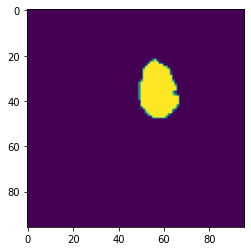

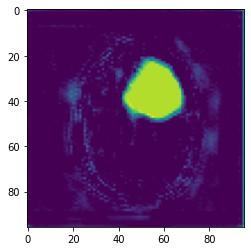

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


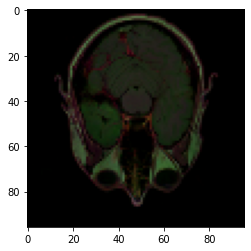

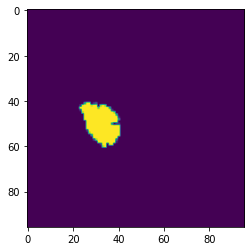

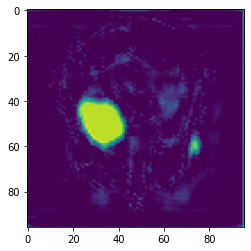

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


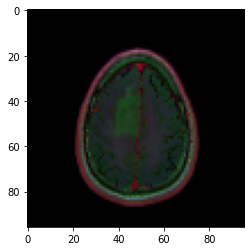

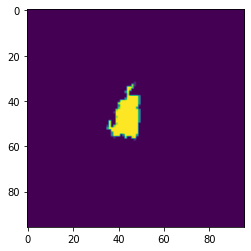

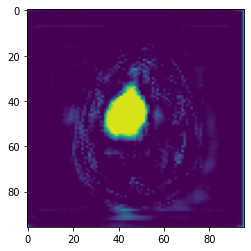

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


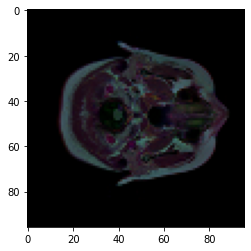

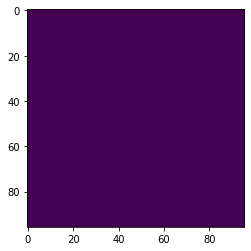

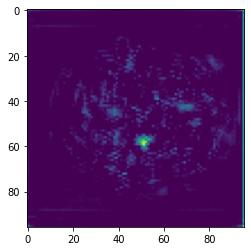

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


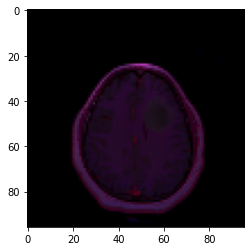

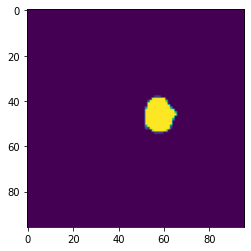

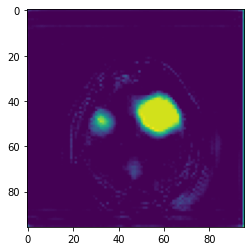

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


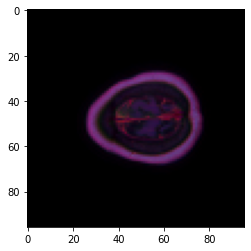

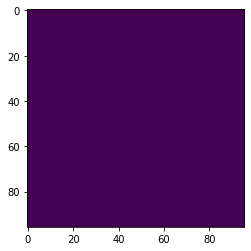

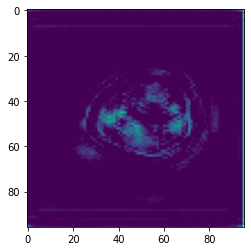

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


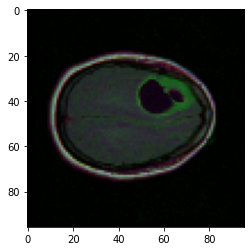

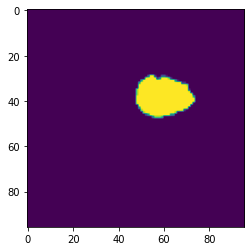

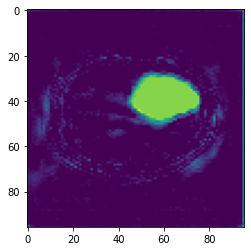

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


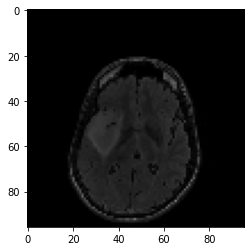

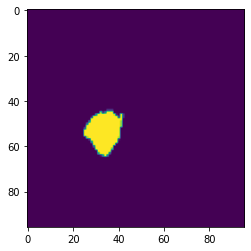

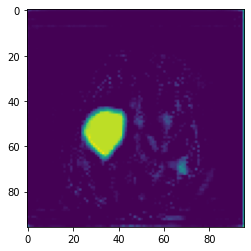

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


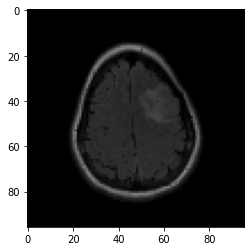

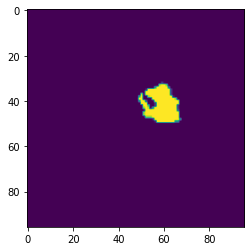

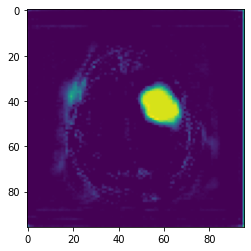

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


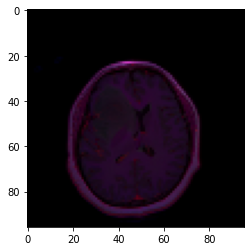

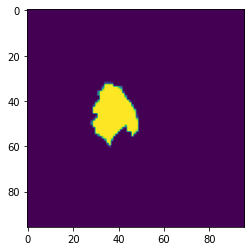

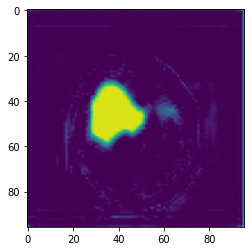

In [ ]:
visual_images, visual_masks = next(iter(trainloader))

visual_images = visual_images[:10]
visual_masks = visual_masks[:10]

for i in range(len(visual_images)):
  image = visual_images[i]
  mask = visual_masks[i]

  image = image.permute(1,2,0)
  mask = mask.permute(1,2,0)
  mask = mask.squeeze()

  plt.imshow(image)
  plt.show()
  plt.imshow(mask)
  plt.show()

  image = image.unsqueeze(1)
  image = image.permute(1,3,0,2)
  output = model(image)
  image = image.squeeze()

  output = output.squeeze()
  output = output.detach().numpy()

  plt.imshow(output)
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


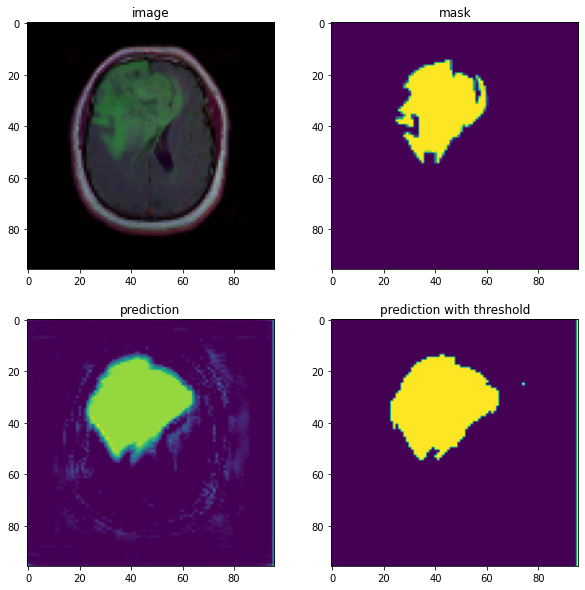

In [ ]:
visual_images, visual_masks = next(iter(testingloader))

visual_images = visual_images[:1]
visual_masks = visual_masks[:1]

for i in range(len(visual_images)):
  image = visual_images[i]
  mask = visual_masks[i]
  image = image.unsqueeze(1)
  image = image.permute(1,0,2,3)
  output = model(image)
  output = output.detach().numpy()
  output = output.squeeze()
  pred_t = output.copy()
  pred_t[np.nonzero(pred_t < 2)] = 0.
  pred_t[np.nonzero(pred_t >= 2)] = 1.
  pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

image = image.squeeze()
image = image.permute(1,2,0)
mask = mask.permute(1,2,0)
mask = mask.squeeze()
ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(output)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()